In [1]:
#Making the necessary imports
import os
import numpy as np
from numpy import matrix
import scipy.optimize as theMinimiser
from iminuit import Minuit
import math
import matplotlib.pyplot as plt
import scipy
import scipy.integrate as integrate
from scipy.stats import norm
from scipy.special import erfinv

%matplotlib inline

## Problem 1 (3 points):

In [2]:
# background parameters
XMIN = 0.
XMAX = 20.
intercept = 20.
slope = -1.
# signal parameters
mean = 10.
sigma = 0.5
# chose number of bins that is appropriate for the size of the statistics sample
NBINS = 100

### Creating the background and signal classes

In [3]:
class Linear:
    def __init__(self, intercept, slope, XMIN, XMAX):
        self.mass = []

        self.intercept = intercept
        self.slope = slope
        self.lolimit = XMIN
        self.hilimit = XMAX
        
    def maxval(self):
        return self.intercept 
        
    # Evaluate method (un - normalised )
    def evaluate(self, x):
        linear_dist = self.intercept + (self.slope * x)
        return linear_dist
    

    def next(self):
        doLoop = True
        while (doLoop):
        # start with uniform random number in [ lolimit , hilimit )
            x = np.random.uniform(self.lolimit, self.hilimit)
            y1 = self.evaluate(x)
            y2 = np.random.uniform(0, self.maxval())
            #print(self.maxval())
            if (y2 < y1):
                filtered_x = x
                self.mass.append(filtered_x)
                return filtered_x   
            
            

In [4]:
class Gaussian:
    def __init__(self, mean, sigma):
        self.mass = []
        
        self.mean = mean
        self.sigma = sigma
        
    def next(self):
        gaussian_dist = np.random.normal(self.mean,self.sigma)
        self.mass.append(gaussian_dist)
        return gaussian_dist
    
    def integrate(self,lower_lim,upper_lim) :
        gaussian = lambda x: (1/(self.sigma*np.sqrt(2*math.pi)))*np.exp((-1/2)*((x-self.mean)/self.sigma)**2)
        integral, _ = integrate.quad(gaussian,lower_lim,upper_lim)
        return integral

### Creating class to sum the background and signal distributions,  weighted by the fractions of background and signal events

In [5]:
class SignalWithBackground:
    def __init__(self, mean, sigma, sig_fraction, intercept, slope, XMIN, XMAX):
        self.mean = mean
        self.sigma = sigma
        self.sig_fraction = sig_fraction
        self.intercept = intercept
        self.slope = slope
        self.XMIN = XMIN
        self.XMAX = XMAX
        self.signal = Gaussian(mean,sigma)
        self.background = Linear(intercept, slope, XMIN, XMAX)
        self.mass_sig = []
        self.mass_bgd = []
        self.mass = [] 
    
    # Draw random number from distribution
    def next(self):
        q = np.random.uniform()
        if(q < self.sig_fraction):
            # if here , we will draw x from signal distribution
            filtered_x = self.signal.next()
            self.mass_sig.append(filtered_x)
        else:
            # if here , we will draw x from background distribuion
            filtered_x = self.background.next()
            self.mass_bgd.append(filtered_x)
        self.mass.append(filtered_x)
        return filtered_x

### Creating function to plot the distributions

In [6]:
# Main code to generate and plot a single experiment
def singleToy(nevents_sig, nevents_bgd):
    sig_fraction = nevents_sig/(nevents_bgd+nevents_sig)
    
    # Create the pdf
    pdf = SignalWithBackground(mean, sigma, sig_fraction, intercept, slope, XMIN, XMAX)
    for i in range (nevents_sig + nevents_bgd): pdf.next()
        
    # retrieve the mass values for signal, background and their sum
    data = pdf.mass
    sig_data = pdf.mass_sig
    bgd_data = pdf.mass_bgd
    
    # plot things on same page
    myRange = (XMIN, XMAX)
    fig, axs = plt.subplots(3, 1, sharex ="col" ,figsize=(5,10))
    axs[0].set_title("Signal distribution (" + str(len(sig_data)) + " entries)")
    axs[1].set_title("Background distribution (" + str(len(bgd_data)) + " entries)")
    axs[2].set_title("Total distribution (" + str(len(data)) + " entries)")
    axs[2].set_xlabel("X")
    axs[0].hist(sig_data, bins=NBINS, range=myRange)
    axs[1].hist(bgd_data, bins=NBINS)
    axs[2].hist(data, bins=NBINS)
    fig.tight_layout()
    plt.savefig("Signal, background and combined distributions.pdf")

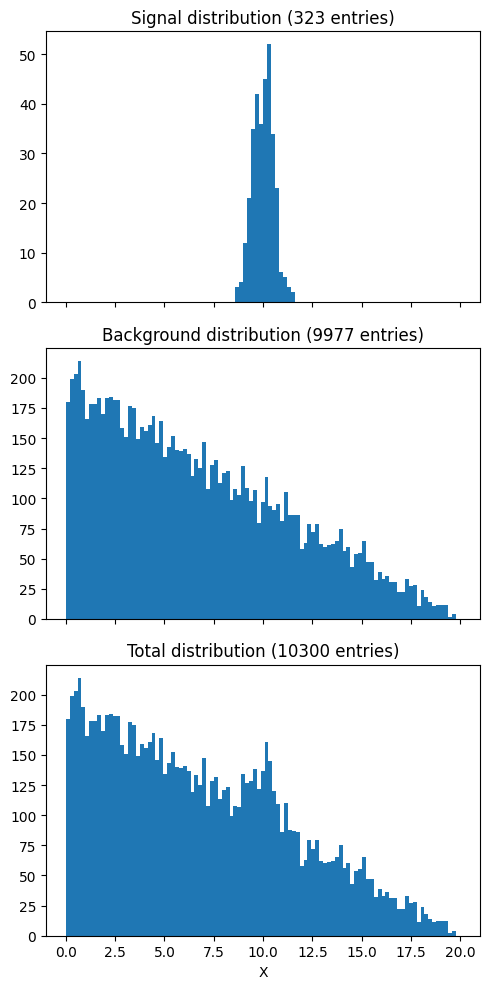

In [7]:
singleToy(nevents_sig=300, nevents_bgd=10000)

## Problem 2 (1 point):

The p-value corresponds to the probability of obtaining test results that are at least as extreme as the results that have been observed. 

In [8]:
mean = 10000
sigma = 100

In [9]:
area_of_observation = Gaussian(mean,sigma).integrate(10300,(10000+(10*sigma))) # this is normalised to is technically 
                                                                               # already the p-value
total_area = Gaussian(mean,sigma).integrate((10000-(10*sigma)),(10000+(10*sigma)))

In [10]:
pvalue = area_of_observation/total_area
print("The p-value is: ",pvalue)

The p-value is:  0.0013498980316301115


In [11]:
# Calcualting the Z-score
n_sigmas = erfinv(1-pvalue)*np.sqrt(2)
print("The Z-score is: ",n_sigmas)

The Z-score is:  3.2051549205989076


## Problem 3 (1 point):

Confirming the total number of background events between 5<x<15 is 50% of the total

In [12]:
pdf = SignalWithBackground(mean, sigma, 0, intercept, slope, XMIN, XMAX)
for i in range (10000): pdf.next()
bgd_data = np.array(pdf.mass_bgd)

In [13]:
number_in_subregion = np.where((bgd_data<15) & (bgd_data>5))[0].shape[0]
total_number_background = bgd_data.size
fraction = number_in_subregion/total_number_background

In [14]:
print("Fraction of background events in the sub-region 5<x<15 is: ",fraction)

Fraction of background events in the sub-region 5<x<15 is:  0.5017


We expect this fraction to be 50% as the distribution is linear between 0 and 20, but the spread fluctuates and the fraction is slightly different at each generation of the pdf, with it averaging to 50% over many initialisations of the distribution.

In [15]:
mean = 5000
sigma = np.sqrt(5000)

In [16]:
area_of_observation = Gaussian(mean,sigma).integrate(5300,(5000+(10*sigma))) # this is normalised to is technically 
                                                                               # already the p-value
total_area = Gaussian(mean,sigma).integrate((5000-(10*sigma)),(5000+(10*sigma)))

In [17]:
pvalue = area_of_observation/total_area
print("The p-value is: ",pvalue)

The p-value is:  1.1045248499292971e-05


In [18]:
# Calcualting the Z-score
n_sigmas = erfinv(1-pvalue)*np.sqrt(2)
print("The Z-score is: ",n_sigmas)

The Z-score is:  4.3956289210855894


Why did the number of standard deviations (Z-score) increase after we filtered the background?:

The deviation is a lot more significant now as the fraction of events that are observed above the expected number is now a larger portion of the expected number of events. This is because we filtered down the number of background events while the number of signal events was kept the same.

This results in the number of observed events to deviate more extremely from the expected number of background events (in our case the deviation is more than 4 standard deviations away from the average results that would be expected if there was no signal). This significantly increases the likelihood of the alternate hypothesis of a signal being present which does not conform to the background distribution.

## Problem 4 (5 points):

### Resetting the parameters

In [19]:
# background parameters
XMIN = 0.
XMAX = 20.
intercept = 20.
slope = -1.
# signal parameters
mean = 10.
sigma = 0.5
# chose number of bins that is appropriate for the size of the statistics sample
NBINS = 100

In [20]:
# Using the new signal count
nevents_sig = 150
nevents_bgd = 10000

### Plotting the new distributions

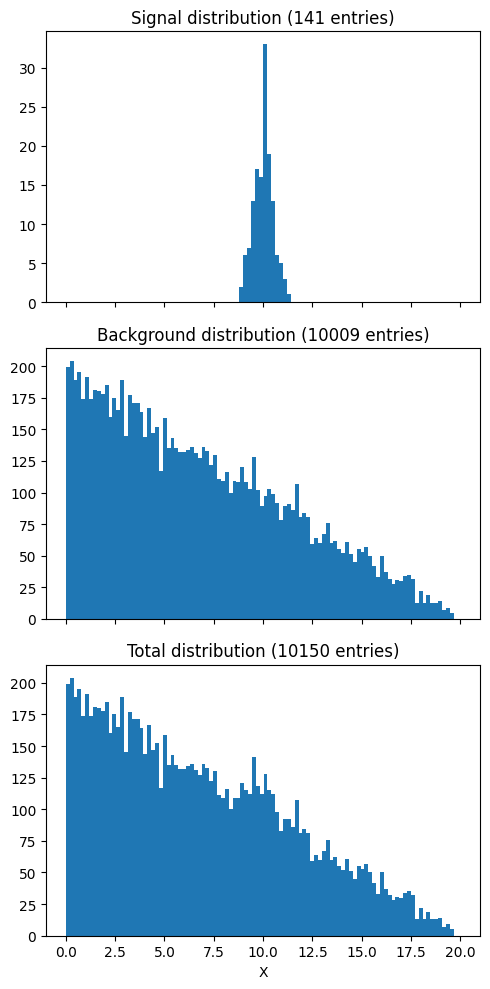

In [21]:
# Plotting the distributions again
singleToy(nevents_sig=nevents_sig, nevents_bgd=nevents_bgd)

### Generating the updated datasets

In [22]:
nevents_sig = 150
nevents_bgd = 10000

sig_fraction = nevents_sig/(nevents_bgd+nevents_sig)
    
# Create the pdf
pdf = SignalWithBackground(mean, sigma, sig_fraction, intercept, slope, XMIN, XMAX)
for i in range (nevents_sig + nevents_bgd): pdf.next()
data = pdf.mass
sig_data = pdf.mass_sig
bgd_data = pdf.mass_bgd

### Defining the probability density functions

In [23]:
# Generate the normalised exponential PDF
def Linear_PDF(x,intercept,slope,x_low,x_high):
    linear_dist = lambda x: intercept + slope*(x)
    area, _ = integrate.quad(linear_dist,x_low,x_high) # Calculate the normalisation constant
    return (1/area)*(intercept + slope*(x))  # Return the normalised exponential PDF

In [24]:
def gauss_PDF(x):
    return scipy.stats.norm.pdf(x,mean,sigma)

In [25]:
def combined_PDF(x,intercept,slope,F,x_low,x_high):
    PDF1 = Linear_PDF(x,intercept,slope,x_low,x_high)
    PDF2 = gauss_PDF(x)
    
    return ((1-F) * PDF1) + (F * PDF2)

In [26]:
bin_width = XMAX/NBINS

### Fitting assuming no signal

In [40]:
(np.histogram(data,bins = np.linspace(0,20,101))[0]).sum()

10150

In [42]:
(nevents_bgd+nevents_sig)*bin_width*Linear_PDF(np.linspace(0.1,19.9,100),intercept,slope,XMIN,XMAX).sum()

10149.999999999998

In [27]:
#create a function for the chi squared linear fit
def chisq_linear(slope,intercept):
    n_observed = np.histogram(data,bins = np.linspace(0,20,101))[0]
    n_expected = (nevents_bgd+nevents_sig)*bin_width*Linear_PDF(np.linspace(0.1,19.9,100),intercept,slope,XMIN,XMAX)
    chi_sq_sum = 0
    for i in range(0,NBINS):
        if n_expected[i] < 0:
            n_expected[i] = 1e-3
        chi_sq_sum += (n_expected[i]-n_observed[i])+(n_observed[i]*np.log(n_observed[i]/n_expected[i]))
    chi_sq = 2*chi_sq_sum
    return chi_sq

In [28]:
# Setting the range of our mass data for use in normalisation
x_low = 0 
x_high = 20.

# Set the minimisation parameters
m = Minuit(chisq_linear, intercept=19, slope=-1.1)
m.limits["intercept"] = (15,25) 
m.limits["slope"] = (-1.5,-0.5)

# Set the errors on the initial start values
m.errors=[0.1,0.1]

# Set the increase in Chi squared for the 1-SD error calculation
m.errordef=1.0

# Run the minimisation
m = m.migrad()

In [29]:
# Printing the final results and their error
fstr = "{0:2.4f}"
val = m.values["intercept","slope"]
err = m.errors["intercept","slope"]
print("{:2s}".format("intercept"), "=  ", fstr.format(val[0]), " +/- ", fstr.format(err[0]))
print("\n")
print("{:2s}".format("slope"), "=  ", fstr.format(val[1]), " +/- ", fstr.format(err[1]))

intercept =   20.3489  +/-  0.3937


slope =   -1.0197  +/-  0.0197


In [30]:
print("Actual intercept:", intercept)
print("Actual slope:", slope)

Actual intercept: 20.0
Actual slope: -1.0


All of the fitted values are correct to within the error margin, showing that a good fit was made

In [31]:
# Collecting the final fit values
h0_fit_values = m.values["intercept","slope"]

### Fitting assuming a gaussian signal

In [32]:
# Create function for chi squared combined fit
def chisq_combined(slope,intercept,F):
    n_observed = np.histogram(data,bins = np.linspace(0,20,101))[0]
    n_expected = (nevents_bgd+nevents_sig)*bin_width*combined_PDF(np.linspace(0.1,19.9,100),intercept,slope,F,XMIN,XMAX)
    chi_sq_sum = 0
    for i in range(0,NBINS):
        if n_expected[i] <= 0:
            n_expected[i] = 1e-3
        chi_sq_sum += (n_expected[i]-n_observed[i])+(n_observed[i]*np.log(n_observed[i]/n_expected[i]))
    chi_sq = 2*chi_sq_sum
    return chi_sq

In [33]:
# Setting the range of our mass data for use in normalisation
x_low = 0 
x_high = 20.

# Set the minimisation parameters
m = Minuit(chisq_combined, intercept=19, slope=-1.1,F=0.01)
m.limits["intercept"] = (15,25) 
m.limits["slope"] = (-1.5,-0.5)
m.limits["F"] = (0.0,0.1)

# Set the errors on the initial start values
m.errors=[0.1,0.1,0.1]

# Set the increase in Chi squared for the 1-SD error calculation
m.errordef=1.0

# Run the minimisation
m = m.migrad()

In [34]:
# Printing the final results and their error
fstr = "{0:2.4f}"
val = m.values["intercept","slope","F"]
err = m.errors["intercept","slope","F"]
print("{:2s}".format("intercept"), "=  ", fstr.format(val[0]), " +/- ", fstr.format(err[0]))
print("\n")
print("{:2s}".format("slope"), "=  ", fstr.format(val[1]), " +/- ", fstr.format(err[1]))
print("\n")
print("{:2s}".format("signal fraction"), "=  ", fstr.format(val[2]), " +/- ", fstr.format(err[2]))

intercept =   20.4529  +/-  1.4304


slope =   -1.0160  +/-  0.0718


signal fraction =   0.0159  +/-  0.0033


In [35]:
print("Actual intercept:", intercept)
print("Actual slope:", slope)
print("Actual signal fraction:", (len(sig_data)/(len(sig_data)+len(bgd_data))))

Actual intercept: 20.0
Actual slope: -1.0
Actual signal fraction: 0.013694581280788177


All of the fitted values are correct to within the error margin, showing that a good fit was made

In [36]:
# Collecting the final fit values
h1_fit_values = m.values["intercept","slope","F"]

### Calculating the chi-squared difference between the two hypotheses

In [37]:
# Using the combined "nested" hypothesis to determine chi-squared for h0 and h1
h0_chi_squared = chisq_combined(intercept=h0_fit_values[0], slope=h0_fit_values[1], F=0)
h1_chi_squared = chisq_combined(intercept=h1_fit_values[0], slope=h1_fit_values[1], F=h1_fit_values[2])

In [38]:
print("Chi-squared for h0: ",h0_chi_squared)

Chi-squared for h0:  114.91716261389219


In [39]:
print("Chi-squared for h1: ",h1_chi_squared)

Chi-squared for h1:  89.57851539337628


In [40]:
chi_squared_diff = h0_chi_squared - h1_chi_squared
print("Chi-squared difference between the two hypotheses: ",chi_squared_diff)

Chi-squared difference between the two hypotheses:  25.33864722051591


### Finding the p-value

In [41]:
pvalue = 1 - scipy.stats.chi2.cdf(chi_squared_diff,1) 
print("The p-value is: ",pvalue)

The p-value is:  4.809748138656644e-07


### Finding the Z-score

In [42]:
n_sigmas = erfinv(1 - pvalue )* np.sqrt(2)
print("The Z-score is: ",n_sigmas)

The Z-score is:  5.033750810370506


These results show that for this signal to be a fluctuation, this fluction would occur over 4 standard deviations away from the average results that would be expected if there was no signal. This means the hypothesis that there is a signal is strongly favoured as such a fluctuation is highly improbable.